In this notebook I run statistical learning models on residential home sales in the Bell school area of Chicago, a highly gentrifying neighborhood with a large number of flipping and teardowns, to demonstrate that models with no inherent bias in their method lead to biased results, overvaluing low priced homes and undervaluing high priced homes. This is not surprising since it is a basic property of models based on averaging. The problem, regression towards the mean, is so intrinsic to these methods that the basic method bares its name. This property exasperates inequality as it leads to lesser taxation of wealthy people and higher taxation on poor people. The results could be used to advocate for a transition from property tax to income tax as was recently attempted in Illinois.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
#from library.sb_utils import save_file
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import pickle
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
bell_2020 = pd.read_csv('../data/bell_cleaned.csv')
bell_sales = pd.read_csv('../data/bell_sales_cleaned.csv')

In [3]:
bell_sales.head()

,Unnamed: 0,meta_pin,meta_year,meta_class,meta_sale_price,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude
0,126575,13242020170000,2017.0,278,850000.0,3050.0,18.0,8.0,4.0,0.0,2.0,1.0,2340.0,-87.690565,41.953323
1,126576,13242020180000,2013.0,278,1055000.0,3050.0,2.0,9.0,4.0,3.0,3.0,1.0,2639.0,-87.690473,41.953324
2,126578,13242030020000,2013.0,203,330000.0,3137.0,54.0,6.0,3.0,0.0,2.0,0.0,1020.0,-87.690731,41.952804
3,126579,13242030040000,2014.0,202,300000.0,3050.0,116.0,4.0,2.0,0.0,2.0,0.0,680.0,-87.690547,41.952805
4,126580,13242030110000,2018.0,206,976711.0,3660.0,96.0,7.0,4.0,1.0,2.0,1.0,2778.0,-87.689729,41.952810


In [4]:
bell_sales['one_story'] = [1 if x < 205 else 0 for x in bell_sales['meta_class']]
bell_sales['row_house'] = [1 if ((x == 210) or (x==295)) else 0 for x in bell_sales['meta_class']]
bell_sales = bell_sales.drop(columns='meta_class')
bell_new = bell_sales[bell_sales.char_age<70]
bell_old = bell_sales[bell_sales.char_age>70]
old_y = bell_old.meta_sale_price
old_X = bell_old.drop(['Unnamed: 0','meta_pin','meta_sale_price'],axis=1)
new_y = bell_new.meta_sale_price
new_X = bell_new.drop(['Unnamed: 0','meta_pin','meta_sale_price'],axis=1)
oldX_train, oldX_test, oldy_train, oldy_test = train_test_split(old_X, old_y, test_size=0.2, random_state=42)
newX_train, newX_test, newy_train, newy_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)
oldscaler = StandardScaler()
oldscaler.fit(oldX_train)
oldX_train= oldscaler.transform(oldX_train)
oldX_test = oldscaler.transform(oldX_test)
newscaler = StandardScaler()
newscaler.fit(newX_train)
newX_train= newscaler.transform(newX_train)
newX_test = newscaler.transform(newX_test)
y_train = np.append(oldy_train,newy_train)
y_test  = np.append(oldy_test,newy_test)

<AxesSubplot:xlabel='meta_sale_price', ylabel='Count'>

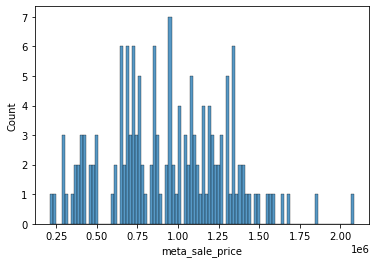

In [5]:
sns.histplot(x=old_y,bins=100)

<AxesSubplot:xlabel='meta_sale_price', ylabel='Count'>

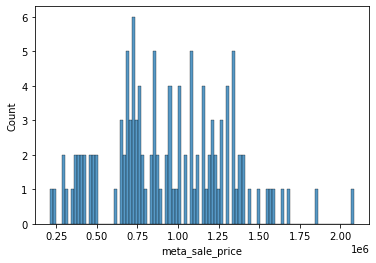

In [6]:
sns.histplot(x=oldy_train,bins=100)

<AxesSubplot:xlabel='meta_sale_price', ylabel='Count'>

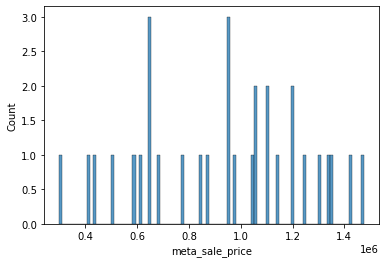

In [7]:
sns.histplot(x=oldy_test,bins=100)

scaling is needed for models that need to determine a 'distance" between data points. But for models, such as decesion trees, that do not require a distance, it is not required.Scaling should do no harm when it is not needed. 

First just try metrics for the mean value of the training data

In [8]:
olddumb_reg = DummyRegressor(strategy='mean')
olddumb_reg.fit(oldX_train,oldy_train)
oldy_tr_pred = olddumb_reg.predict(oldX_train)
oldy_te_pred = olddumb_reg.predict(oldX_test)
newdumb_reg = DummyRegressor(strategy='mean')
newdumb_reg.fit(newX_train,newy_train)
newy_tr_pred = newdumb_reg.predict(newX_train)
newy_te_pred = newdumb_reg.predict(newX_test)
y_tr_pred = np.append(oldy_tr_pred,newy_tr_pred)
y_te_pred = np.append(oldy_te_pred,newy_te_pred)


In [9]:

mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.4143511417357404,
 0.3797135583481504,
 0.18801206290947958,
 0.2293896671338448,
 397671.82031537476,
 383442.7490709116,
 331433.71194597444,
 314106.7557187131)

Three metrics recommended by the International association of assessing officers based on the ratio y_pred/y_test are Coefficient of Dispersion (COD), Price Related Differential (PRD), and Coefficent of Price-Related Bias.

Coefficient of Dispersion (COD)is a measure of the variance of the ratio. It is multiplied by 100. Its value is the percentage variation of the ratio away from the median. It does not tell us if low priced homes are being treated differently than high priced homes.

In [10]:
def cod(y_pred,y_test):
    ratio = y_pred/y_test
    ratio_median = np.median(ratio)
    return 100*np.mean(np.abs(ratio-ratio_median))/ratio_median
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(39.69569142405838, 38.512694336152954)

Just taking an average produces a variation of over 40% is the ratio.


Price Related Differential does tell us if low priced homes are being treated differently than high priced homes. It is the mean ratio divided by the sales price weighted mean ratio. If the ratio for large sales price homes is lower than the ratio for low sales price homes, then the mean ratio over the weighted mean ratio will be larger than 1.

In [11]:
def prd(y_pred,y_test):
    ratio = y_pred/y_test
    y_test_sum = np.sum(y_test)
    y_pred_sum = np.sum(y_pred)
    return np.mean(ratio)*y_test_sum/y_pred_sum
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.2019051319836271, 1.179662689867536)

The mean ratio is 22% higher than the weighted mean ratio, indicating that low proced homes are priced higher than their sales price compared to how high priced homes are treated.  This is a consequence that small variations in the predicated price of a low priced home makes a bigger change in the ratio.

Coefficent of price related bias (PRB) does a liner regression between the log2 of the price and the ratio. A negative number means that if one increases the price, the ratio goes down.

In [12]:
def prb(y_pred,y_test):
    proxy = 0.5*(y_pred + y_test)
    ln_value = pd.DataFrame(np.log2(proxy))
    ratio = y_pred/y_test
    ratio_median = np.median(ratio)
    pct_dif = (ratio - ratio_median)/ratio_median
    lr = LinearRegression()
    lr.fit(ln_value,pct_dif)
    return lr.coef_
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-1.18620674]), array([-1.10707835]))

Using the average price for all predictions has the consequence that doubling the price of the home means the ratio goes down by 78%.

Next we see how linear regression improves predicted prices.  

In [13]:
oldlm = LinearRegression()
oldlm.fit(oldX_train,oldy_train)
oldy_tr_pred = oldlm.predict(oldX_train)
oldy_te_pred = oldlm.predict(oldX_test)
newlm = LinearRegression()
newlm.fit(newX_train,newy_train)
newy_tr_pred = newlm.predict(newX_train)
newy_te_pred = newlm.predict(newX_test)
y_tr_pred = np.append(oldy_tr_pred,newy_tr_pred)
y_te_pred = np.append(oldy_te_pred,newy_te_pred)

In [14]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.15677297049208067,
 0.17357268314248822,
 0.8150759333415336,
 0.7025780862906984,
 189778.38489508745,
 238215.2702341796,
 143160.37219917122,
 174462.68764887485)

In [15]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(15.71694195111256, 17.82154454864478)

variance is cut by more than half

In [16]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0396950132303933, 1.0212517608856664)

mean ratio is now only 7 percent higher than the weighted ratio.

In [17]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.09542023]), array([0.0212858]))

In [18]:
oldlm.coef_,oldlm.intercept_,newlm.coef_,newlm.intercept_

(array([-10895.82367375,  67730.47895218,  63067.64205042,  10928.84255503,
         46488.37189424,   6116.92846508, -24348.66066931,  10348.8780544 ,
        190371.24503978,   1279.9497371 , -20341.82159791, -65341.2706774 ,
             0.        ]),
 937621.5206611354,
 array([  24212.94425225,  104786.60213134, -106392.82008187,
        -108816.23925504,   42020.33650794,   32165.65968728,
          27903.82584742,  -14603.19450054,  186511.81922297,
         149267.74652577,  -10757.90949339,    6816.27987839,
         -10949.05364465]),
 1320620.0535712445)

<AxesSubplot:>

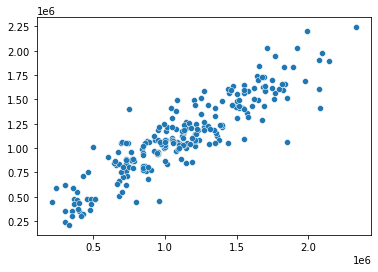

In [19]:
sns.scatterplot(x=y_train,y=y_tr_pred)

<AxesSubplot:>

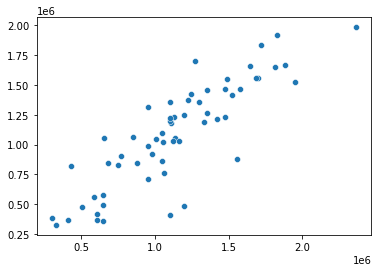

In [20]:
sns.scatterplot(x=y_test,y=y_te_pred)

<AxesSubplot:>

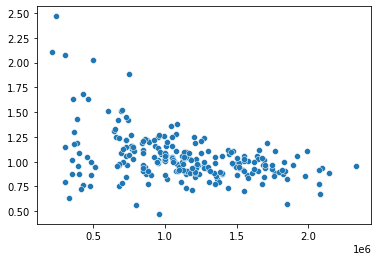

In [21]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

<AxesSubplot:>

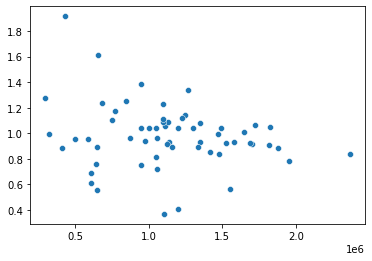

In [22]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

<AxesSubplot:>

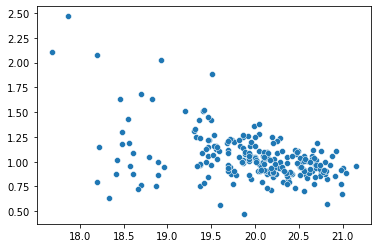

In [23]:
sns.scatterplot(x=np.log2(y_train),y=y_tr_pred/y_train)

<AxesSubplot:>

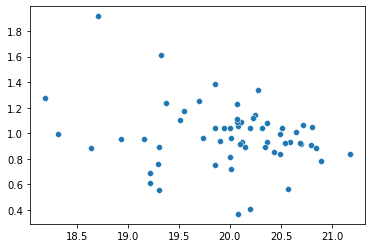

In [24]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

For linear regression, doubling the home price means the ratio goes down by almost 14%. Let's see how much this can be improved with ElasticNet which includes LinearRegression as a limit.

In [25]:
olden = ElasticNet()
params = {'alpha':[0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}
olden_gscv = GridSearchCV(olden,params,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")
olden_gscv.fit(oldX_train,oldy_train)
oldy_tr_pred = olden_gscv.predict(oldX_train)
oldy_te_pred = olden_gscv.predict(oldX_test)
newen = ElasticNet()
newen_gscv = GridSearchCV(newen,params,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")
newen_gscv.fit(newX_train,newy_train)
newy_tr_pred = newen_gscv.predict(newX_train)
newy_te_pred = newen_gscv.predict(newX_test)
y_tr_pred = np.append(oldy_tr_pred,newy_tr_pred)
y_te_pred = np.append(oldy_te_pred,newy_te_pred)

In [26]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.1563404515815608,
 0.16388665318967818,
 0.8070315193843075,
 0.7202854247404956,
 193862.2358436359,
 231015.25757072383,
 144433.9278994814,
 165814.57392778157)

In [27]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(15.38494252979168, 16.497437526538647)

In [28]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0489764140243452, 1.0307539255941793)

In [29]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.14581773]), array([-0.03281535]))

In [30]:
olden_gscv.best_params_, newen_gscv.best_params_

({'alpha': 0.7, 'l1_ratio': 0.7}, {'alpha': 0.4, 'l1_ratio': 0.7})

<AxesSubplot:>

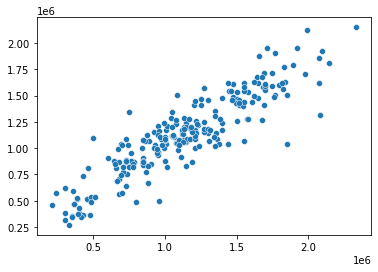

In [31]:
sns.scatterplot(x=y_train,y=y_tr_pred)

<AxesSubplot:>

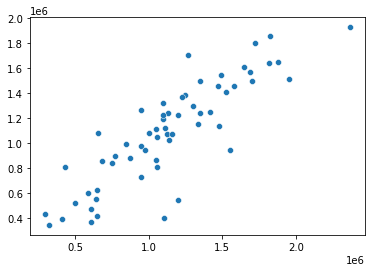

In [32]:
sns.scatterplot(x=y_test,y=y_te_pred)

<AxesSubplot:>

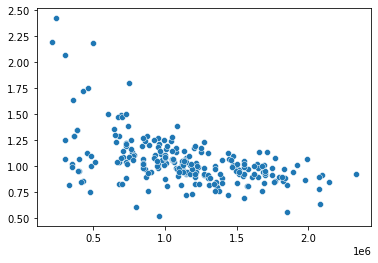

In [33]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

<AxesSubplot:>

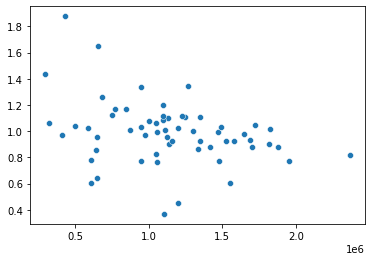

In [34]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

<AxesSubplot:>

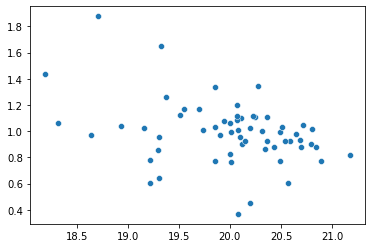

In [35]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

For linear regression, doubling the home price means the ratio goes down by almost 14%. Can this be improved with Random Forest?

In [36]:
oldrfr= RandomForestRegressor(random_state=42)
params = {'n_estimators':[100,200,300,400,500],'criterion':["squared_error", "absolute_error", "poisson"],'max_features':["auto","sqrt","log2"]}
oldrfr_gscv = GridSearchCV(oldrfr,params,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")
oldrfr_gscv.fit(oldX_train,oldy_train)
oldy_tr_pred = oldrfr_gscv.predict(oldX_train)
oldy_te_pred = oldrfr_gscv.predict(oldX_test)
newrfr = RandomForestRegressor(random_state=42)
newrfr_gscv = GridSearchCV(newrfr,params,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")
newrfr_gscv.fit(newX_train,newy_train)
newy_tr_pred = newrfr_gscv.predict(newX_train)
newy_te_pred = newrfr_gscv.predict(newX_test)
y_tr_pred = np.append(oldy_tr_pred,newy_tr_pred)
y_te_pred = np.append(oldy_te_pred,newy_te_pred)

In [37]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)


(0.057826550203064875,
 0.1509992157658674,
 0.9697579802487063,
 0.772408551073966,
 76745.9426703048,
 208382.42416471796,
 53386.27759656652,
 143300.734125)

In [38]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(5.754606681941083, 15.352984164419567)

In [39]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0189225747289326, 1.0386850117183772)

In [40]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.07632192]), array([-0.10450066]))

In [41]:
oldrfr_gscv.best_params_, newrfr_gscv.best_params_

({'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 100},
 {'criterion': 'squared_error', 'max_features': 'auto', 'n_estimators': 400})

<AxesSubplot:>

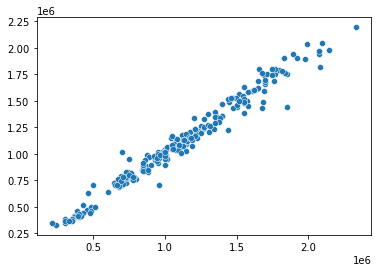

In [42]:
sns.scatterplot(x=y_train,y=y_tr_pred)

looks good on training data

<AxesSubplot:>

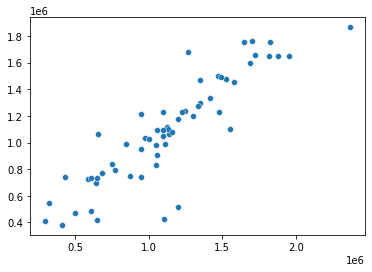

In [43]:
sns.scatterplot(x=y_test,y=y_te_pred)

less good on the test data

<AxesSubplot:>

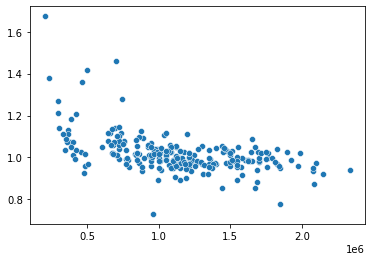

In [44]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

training data ratio is higher for low priced homes. The smallest priced home is valued at twice its sales price.

<AxesSubplot:>

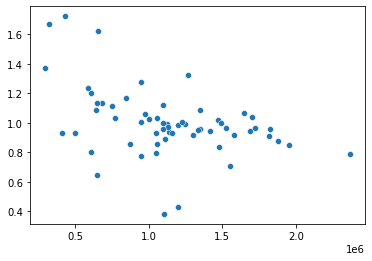

In [45]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

same bias in the test data

<AxesSubplot:>

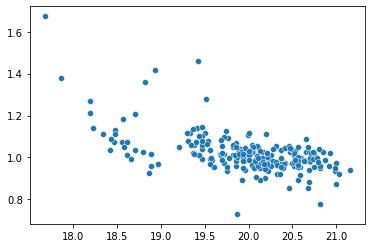

In [46]:
sns.scatterplot(x=np.log2(y_train),y=y_tr_pred/y_train)

<AxesSubplot:>

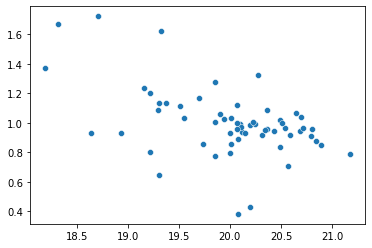

In [47]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

One can also see the downward trend in when graphing against the log of the price. One high priced homes are valued at less than half of its sale price.

In [48]:
oldgb = GradientBoostingRegressor(random_state=42)
oldparams = {'n_estimators':[250,300,350],'learning_rate':[0.01,0.015,0.2],'loss':['squared_error', 'absolute_error'],'max_depth':[1,2,3]}
oldgb_gscv = GridSearchCV(oldgb,oldparams,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")
oldgb_gscv.fit(oldX_train,oldy_train)
oldy_tr_pred = oldgb_gscv.predict(oldX_train)
oldy_te_pred = oldgb_gscv.predict(oldX_test)
newgb = GradientBoostingRegressor(random_state=42)
newparams = {'n_estimators':[600,700,800],'learning_rate':[0.005,0.01,0.015],'loss':['squared_error', 'absolute_error'],'max_depth':[3,4,5]}
newgb_gscv = GridSearchCV(newgb,newparams,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")
newgb_gscv.fit(newX_train,newy_train)
newy_tr_pred = newgb_gscv.predict(newX_train)
newy_te_pred = newgb_gscv.predict(newX_test)
y_tr_pred = np.append(oldy_tr_pred,newy_tr_pred)
y_te_pred = np.append(oldy_te_pred,newy_te_pred)


In [49]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.07515123944568347,
 0.15225269123147542,
 0.8992717281649968,
 0.740509714772916,
 140063.7404100151,
 222506.99438271983,
 67768.43512739796,
 152153.55323774807)

In [50]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(7.517686304614595, 15.232723655263687)

In [51]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.027516451970008, 1.0343093357872999)

In [52]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.09503117]), array([-0.07015787]))

In [53]:
oldgb_gscv.best_params_, newgb_gscv.best_params_

({'learning_rate': 0.015,
  'loss': 'absolute_error',
  'max_depth': 2,
  'n_estimators': 300},
 {'learning_rate': 0.01,
  'loss': 'squared_error',
  'max_depth': 4,
  'n_estimators': 700})

<AxesSubplot:>

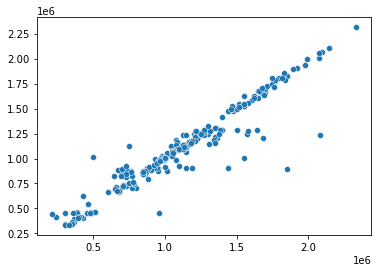

In [54]:
sns.scatterplot(x=y_train,y=y_tr_pred)

<AxesSubplot:>

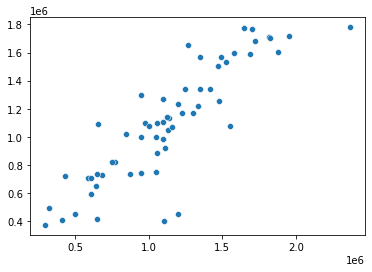

In [55]:
sns.scatterplot(x=y_test,y=y_te_pred)

<AxesSubplot:>

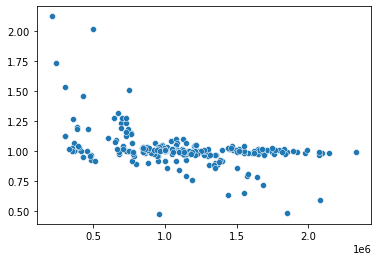

In [56]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

<AxesSubplot:>

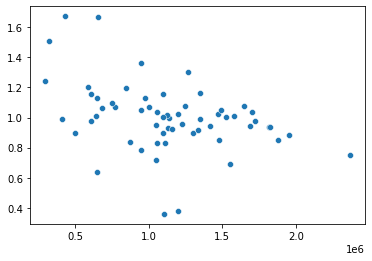

In [57]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

<AxesSubplot:>

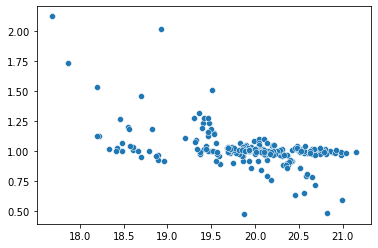

In [58]:
sns.scatterplot(x=np.log2(y_train),y=y_tr_pred/y_train)

<AxesSubplot:>

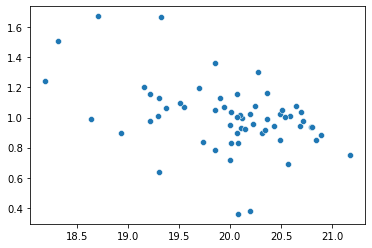

In [59]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

In [60]:
best_model_old = oldrfr_gscv.best_estimator_
best_model_old.version = '1.0'
best_model_old.pandas_version = pd.__version__
best_model_old.numpy_version = np.__version__
best_model_old.sklearn_version = sklearn_version
best_model_old.X_columns = [col for col in old_X.columns]
best_model_old.build_datetime = datetime.datetime.now()
best_model_new = newrfr_gscv.best_estimator_
best_model_new.version = '1.0'
best_model_new.pandas_version = pd.__version__
best_model_new.numpy_version = np.__version__
best_model_new.sklearn_version = sklearn_version
best_model_new.X_columns = [col for col in new_X.columns]
best_model_new.build_datetime = datetime.datetime.now()

In [61]:
#from library.sb_utils import save_file
#modelpath = '../models'
#save_file(best_model_old, 'Bell_old_model.pkl', modelpath)
#save_file(best_model_new, 'Bell_new_model.pkl', modelpath)


In [62]:
bell_2020 = pd.read_csv('../data/bell_cleaned.csv')
bell_2020['one_story'] = [1 if x < 205 else 0 for x in bell_2020['meta_class']]
bell_2020['row_house'] = [1 if ((x == 210) or (x==295)) else 0 for x in bell_2020['meta_class']]
bell_2020 = bell_2020.drop(columns='meta_class')
bell_2020_new = bell_2020[bell_2020.char_age<70]
bell_2020_old = bell_2020[bell_2020.char_age>70]
old_2020_pin = bell_2020_old.meta_pin
old_2020 = bell_2020_old.drop(['Unnamed: 0','meta_pin'],axis=1)
new_2020_pin = bell_2020_new.meta_pin
new_2020 = bell_2020_new.drop(['Unnamed: 0','meta_pin'],axis=1)
old_2020= oldscaler.transform(old_2020)
new_2020 = newscaler.transform(new_2020)

In [63]:
old_2020_pred = best_model_old.predict(old_2020)
new_2020_pred = best_model_new.predict(new_2020)
bell_2020_old['pred_price'] = old_2020_pred
bell_2020_new['pred_price'] = new_2020_pred


/var/folders/qc/g6yf7hvd019dnqj11v94qpbw0000gn/T/ipykernel_20621/3754778141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bell_2020_old['pred_price'] = old_2020_pred
/var/folders/qc/g6yf7hvd019dnqj11v94qpbw0000gn/T/ipykernel_20621/3754778141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bell_2020_new['pred_price'] = new_2020_pred


In [64]:
bell_2020_old.head()

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
1,383982,13242020160000,2020.0,3050.0,127.0,4.0,3.0,0.0,1.0,0.0,1077.0,-87.690657,41.953323,1,0,456149.00
4,383987,13242020210000,2020.0,3050.0,96.0,7.0,3.0,0.0,2.0,1.0,2350.0,-87.690197,41.953325,0,0,817003.26
6,383998,13242030030000,2020.0,3050.0,96.0,6.0,3.0,0.0,1.0,0.0,1510.0,-87.690639,41.952804,1,0,463998.00
8,384000,13242030060000,2020.0,4575.0,98.0,6.0,3.0,0.0,1.0,1.0,1447.0,-87.690340,41.952806,1,0,527396.50
9,384001,13242030070000,2020.0,4575.0,94.0,6.0,3.0,0.0,1.0,0.0,1275.0,-87.690202,41.952807,1,0,462987.00


In [65]:
bell_2020_old[bell_2020_old.meta_pin==13242050130000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
65,384066,13242050130000,2020.0,4125.0,93.0,6.0,3.0,1.0,2.0,0.0,1853.0,-87.689245,41.950997,1,0,537821.18


In [66]:
bell_2020_pred = pd.concat([bell_2020_old,bell_2020_new])

In [67]:
bell_2020_pred[bell_2020_pred.meta_pin==13242050130000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
65,384066,13242050130000,2020.0,4125.0,93.0,6.0,3.0,1.0,2.0,0.0,1853.0,-87.689245,41.950997,1,0,537821.18


In [68]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040270000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
51,384052,13242040270000,2020.0,4125.0,96.0,6.0,3.0,0.0,1.0,0.0,1222.0,-87.689268,41.951521,1,0,478517.0


In [69]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040240000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
48,384049,13242040240000,2020.0,4125.0,96.0,6.0,3.0,0.0,1.0,0.0,1222.0,-87.689632,41.951518,1,0,481044.5


In [70]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040160000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
41,384041,13242040160000,2020.0,3390.0,6.0,8.0,4.0,0.0,3.0,1.0,2090.0,-87.690586,41.95151,0,0,967717.615


In [71]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040150000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
40,384040,13242040150000,2020.0,3391.0,3.0,8.0,5.0,1.0,3.0,1.0,2168.0,-87.690681,41.951511,0,0,998421.39


In [72]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040010000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
27,384027,13242040010000,2020.0,3780.0,95.0,7.0,4.0,1.0,2.0,0.0,1861.0,-87.690691,41.951896,1,0,684386.94


In [73]:
bell_2020_pred[bell_2020_pred.meta_pin==13242030180000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
13,384009,13242030180000,2020.0,3226.0,3.0,6.0,3.0,1.0,2.0,1.0,2171.0,-87.690718,41.952423,0,0,1027633.325


In [74]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040110000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
36,384036,13242040110000,2020.0,4125.0,3.0,7.0,5.0,1.0,4.0,1.0,2677.0,-87.689517,41.951905,0,0,1.191598e+06


In [75]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040100000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
35,384035,13242040100000,2020.0,4125.0,9.0,8.0,3.0,1.0,3.0,1.0,2467.0,-87.689638,41.951904,0,0,1137941.75


In [76]:
bell_2020_pred[bell_2020_pred.meta_pin==13242040140000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
39,384039,13242040140000,2020.0,4125.0,96.0,6.0,3.0,0.0,1.0,0.0,1164.0,-87.689153,41.951909,1,0,455270.0


In [77]:
bell_2020_pred[bell_2020_pred.meta_pin==13242080210000]

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
117,384118,13242080210000,2020.0,3720.0,101.0,5.0,3.0,0.0,1.0,1.0,1359.0,-87.689871,41.947991,1,0,490219.9


In [79]:
#pins = [13242050130000,13242040270000,13242040240000,13242040160000,13242040150000,13242040010000,13242030180000,13242040110000,13242040100000,13242040140000,13242080210000]
bung_pins =[13242050060000,13242050080000,13242050100000,13242050110000,13242050130000]
bell_special = bell_2020_pred[bell_2020_pred.meta_pin.isin(bung_pins)]

In [80]:
bell_special

,Unnamed: 0,meta_pin,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pred_price
58,384059,13242050060000,2020.0,4125.0,96.0,6.0,3.0,0.0,1.0,0.0,1116.0,-87.690093,41.950991,1,0,472954.50
60,384061,13242050080000,2020.0,4125.0,95.0,7.0,4.0,0.0,1.0,0.0,1183.0,-87.689850,41.950993,1,0,702487.01
62,384063,13242050100000,2020.0,4125.0,96.0,6.0,3.0,0.0,2.0,0.0,1920.0,-87.689608,41.950995,1,0,528914.91
63,384064,13242050110000,2020.0,4125.0,96.0,4.0,3.0,0.0,2.0,0.0,1383.0,-87.689487,41.950996,1,0,452133.51
65,384066,13242050130000,2020.0,4125.0,93.0,6.0,3.0,1.0,2.0,0.0,1853.0,-87.689245,41.950997,1,0,537821.18


In [ ]:
bell_sales_special= bell_sales[bell_sales.meta_pin.isin(pins)]

In [ ]:
bell_sales_special

In [ ]:
bell_sales_wrong= bell_sales[(bell_sales.one_story==1) &(bell_sales.meta_sale_price>700000)]

In [ ]:
bell_sales_wrong

In [ ]:
bell_sales_wrong.shape

In [ ]:
bell_sales[(bell_sales.one_story==1)].shape

In [ ]:
curious_pins = bell_sales_wrong.meta_pin

In [ ]:
bell_sales[(bell_sales.meta_pin.isin(curious_pins))&(bell_sales.meta_sale_price<700000)]

In [ ]:
bell_sales_wrong.meta_sale_price.mean()